In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from matplotlib.animation import FuncAnimation
import scienceplots
from matplotlib import rc
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
rc('animation', html='jshtml')

plt.style.use(['science', 'no-latex'])

We will consider a particle of mass $m$ in the one-dimensional potential $V(x) = V_0 \theta(x)$, where $\theta(x)$ is the Heaviside function 
$$
\theta(x) = \begin{cases}
0 \ x<0 \\
1 \ x\geq 0
\end{cases}
$$

The particle's wavefunction evolution is governed by Schrödinger's Equation:
$$ \left(-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}+V(x)\right)\varphi(x) = E\varphi(x)$$

We want to deal with dimensionless quantities. Let $V(x) \rightarrow \frac{\hbar^2}{2m}U(x)$, $E \rightarrow \frac{\hbar^2}{2m}\varepsilon$, for what we obtain

$$ \left(-\frac{1}{2}\frac{\partial^2}{\partial x^2}+U(x)\right)\varphi(x) = \varepsilon \varphi(x)$$

We discretize the derivative for a function $f$ as $f'(x) \approx \frac{f_{i+1}-f_{i-1}}{2\Delta x} \implies f''\approx \frac{f'_{i+1/2}-f'_{i-1/2}}{\Delta x^2}=\frac{f_{i+1}-2f_i+f_{i-1}}{\Delta x^2}$. This way, we obtain the following eigenvalue problem:

$$
\begin{pmatrix}
    \frac{1}{\Delta x^2}+U(x) & -\frac{1}{2 \Delta x^2} & 0 & \dots & 0\\
    -\frac{1}{2 \Delta x^2} & \frac{1}{2 \Delta x^2}+U(x) & -\frac{1}{2 \Delta x^2} & \dots & 0\\
    0 & -\frac{1}{2 \Delta x^2} & \frac{1}{2 \Delta x^2}+U(x) & \ddots & 0\\
    \vdots & \vdots & \ddots & \ddots & -\frac{1}{2 \Delta x^2}\\
    0 & 0 & \dots & -\frac{1}{2 \Delta x^2} & \frac{1}{2 \Delta x^2}+U(x)
\end{pmatrix}
\varphi(x) = E \varphi(x)
$$

We will estimate the energies $\varepsilon_n$ and the corresponding eigenstates $\phi_n(x)$ using an efficient tridiagonal matrix diagonalization algorithm, provided by Scipy package. Once this is done, we will express our solution as an eigenfunction expansion

$$
\varphi(x, t) = \sum_n c_n\phi_n(x) e^{-i\varepsilon_n t}
$$

The coefficients will depend on the initial wavefunction, $\varphi(x,0)$, as they can be obtained from $c_n = \int dx \phi_n^*(x)\varphi(x,0)$. We will work here with a wavepacket at initial time.

In [3]:
def potential(x, U0): 
    N = len(x)
    U = np.zeros(N)
    for i in range(N):
        if i>=int(N/2):
            U[i] = U0
    return U

def psinot(x, x0, k, sigma=1):  
    f = np.exp(-(x-x0)**2/sigma**2)*np.exp(1j*k*(x-x0)) # Wavepacket
    I = np.sum(np.abs(f)**2*(x[1]-x[0])) # Normalize
    return f/np.sqrt(I)

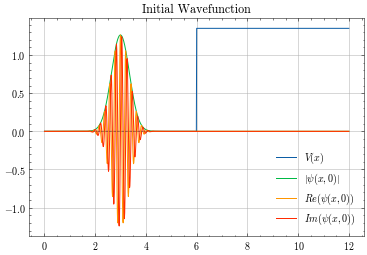

In [4]:
N = 1000
x = np.linspace(0, 12, N+1)
dx = x[1]-x[0]
k, x0, sigma = 30, 3, .5
U0 = k**2/2

U = potential(x[1:-1], U0)
psi0 = psinot(x[1:-1], x0, k, sigma)
plt.plot(x[1:-1], .003*U, label='$V(x)$')
plt.plot(x[1:-1], np.abs(psi0), label=r'$|\psi(x,0)|$')
plt.plot(x[1:-1], np.real(psi0), label=r'$Re(\psi(x,0))$')
plt.plot(x[1:-1], np.imag(psi0), label=r'$Im(\psi(x,0))$')
plt.title('Initial Wavefunction')
plt.legend()
plt.grid()

In [5]:
diagonal, offdiag = 1/dx**2*np.ones(N-1)+U, (-1/(2*dx**2))*np.ones(N-2)
E, phi = eigh_tridiagonal(diagonal, offdiag)
A = np.sum(np.abs(phi[:,0])**2*dx) # Amplitude square of the first eigenfunction, we just take this one for simplicity, as it is approximately equal for all eigenstates
phi = phi.T/np.sqrt(A) # Normalize the eigenfunctions in our domain

def psifun(t):
    c = 0*psi0  # Build the coefficients
    for i in range(0, N-1):
        c[i] = np.sum(np.conj(phi[i])*psi0*dx)    
    psif = phi.T@(c*np.exp(-1j*E*t)) # Total wavefunction
    return psif

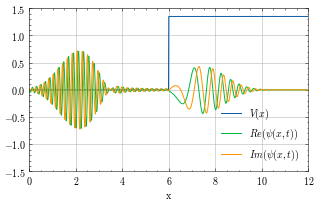

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (5,3))
ln1, = ax.plot([], [], label=r'$V(x)$')
ln2, = ax.plot([], [], label=r'$Re(\psi(x,t))$')
ln3, = ax.plot([], [], label=r'$Im(\psi(x,t))$')
ax.set_xlim(min(x),max(x))
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("x")
ax.grid()
ax.legend()
t = np.linspace(0, 0.25, 100)
n = len(t)

def animate(i): # Animation function
  ln1.set_data(x[1:-1], .003*U)
  ln2.set_data(x[1:-1], np.real(psifun(t[i])))
  ln3.set_data(x[1:-1], np.imag(psifun(t[i])))
  return ln1, ln2, ln3,

FuncAnimation(fig, animate, frames=len(t), interval=30, blit=True)